##**Load the Dataset**
First, download the dataset from Kaggle (S&P 500 Stock Data) and load it into PySpark.

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder \
    .appName("S&P500StockAnalysis") \
    .getOrCreate()

# Load the dataset
file_path = "/content/all_stocks_5yr.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first few rows
df.show(5)

# Print the schema
df.printSchema()

+----------+-----+-----+-----+-----+--------+----+
|      date| open| high|  low|close|  volume|Name|
+----------+-----+-----+-----+-----+--------+----+
|2013-02-08|15.07|15.12|14.63|14.75| 8407500| AAL|
|2013-02-11|14.89|15.01|14.26|14.46| 8882000| AAL|
|2013-02-12|14.45|14.51| 14.1|14.27| 8126000| AAL|
|2013-02-13| 14.3|14.94|14.25|14.66|10259500| AAL|
|2013-02-14|14.94|14.96|13.16|13.99|31879900| AAL|
+----------+-----+-----+-----+-----+--------+----+
only showing top 5 rows

root
 |-- date: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- Name: string (nullable = true)



## Preprocess and Analyze the Data
2.1 Handle Missing Values
Check for missing values and handle them appropriately.

In [4]:
# Check for missing values
from pyspark.sql.functions import isnan, when, count, col

# Select only numeric columns for missing value check
numeric_cols = [c for c, dtype in df.dtypes if dtype in ('double', 'float', 'int', 'bigint')]

# Check for missing values in numeric columns only
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_cols]).show()

# Drop rows with missing values (if any)
df = df.na.drop()

+----+----+---+-----+------+
|open|high|low|close|volume|
+----+----+---+-----+------+
|   1|   1|  1|    0|     0|
+----+----+---+-----+------+



## **2.2 Convert Date Column to Timestamp**
Ensure the Date column is in the correct format for time-series analysis.

In [5]:
from pyspark.sql.functions import to_date

# Convert 'Date' column to timestamp
df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

# Check the updated schema
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- Name: string (nullable = true)



## **2.3 Exploratory Data Analysis (EDA)**
Perform some basic EDA to understand the dataset.

In [6]:
# Summary statistics for numerical columns
df.describe().show()

# Number of unique stocks
df.select("Name").distinct().count()

# Stock with the most data points
df.groupBy("Name").count().orderBy("count", ascending=False).show()

+-------+------------------+------------------+------------------+------------------+--------------------+-----+
|summary|              open|              high|               low|             close|              volume| Name|
+-------+------------------+------------------+------------------+------------------+--------------------+-----+
|  count|             87232|             87232|             87232|             87232|               87232|87232|
|   mean|102.76658000848329|103.72998593177127|101.77403525770212|  102.785599846388|   5308882.724046222| NULL|
| stddev|114.82918393111896|115.84168442095827| 113.7282586735454|114.81944275296327|1.5244127764021507E7| NULL|
|    min|              1.62|              1.69|              1.61|              1.62|                 101|    A|
|    max|           1477.39|            1498.0|           1450.04|           1450.89|           375088650|  BLL|
+-------+------------------+------------------+------------------+------------------+-----------

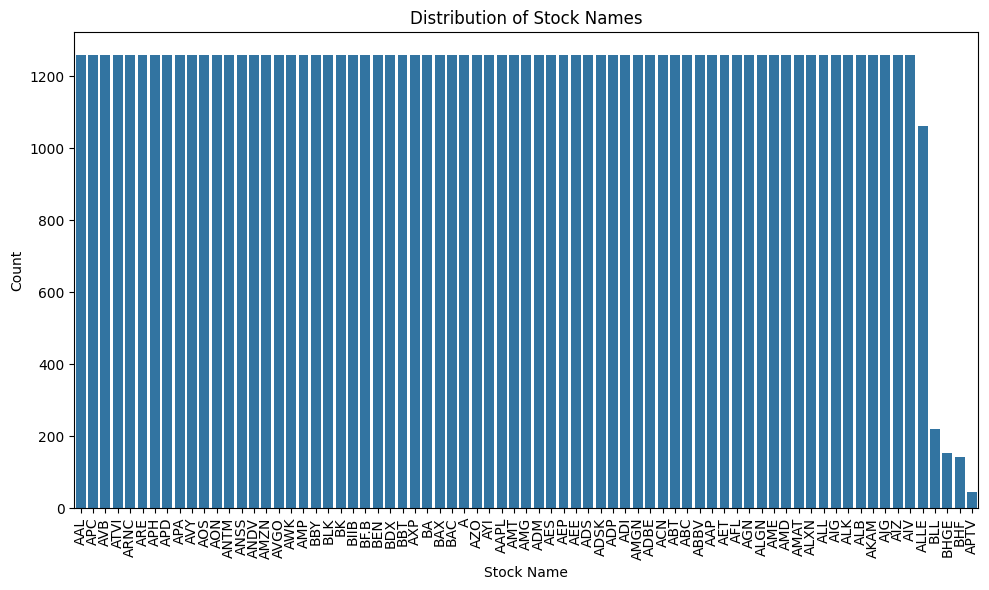

In [7]:
#plotting a countplot
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your PySpark DataFrame

# Select the column you want to plot and convert to Pandas DataFrame
pandas_df = df.select("Name").toPandas()  # Replace "Name" with the desired column

# Create the countplot using Seaborn
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.countplot(x="Name", data=pandas_df, order=pandas_df["Name"].value_counts().index)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("Distribution of Stock Names")  # Add a title
plt.xlabel("Stock Name")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

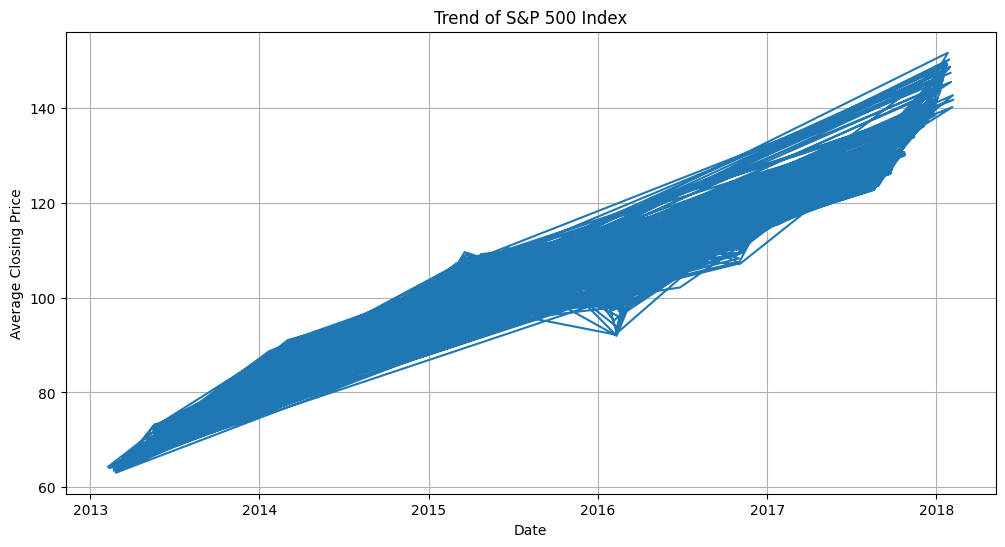

In [8]:
#plotting a trend analysis with a line plot
import matplotlib.pyplot as plt

# Assuming 'df' is your PySpark DataFrame with 'Date' and 'Close' columns

# Aggregate data to daily level (if not already)
daily_df = df.groupBy("Date").agg({"Close": "mean"})

# Convert to Pandas DataFrame for plotting
pandas_df = daily_df.toPandas()

# Create line plot
plt.figure(figsize=(12, 6))
plt.plot(pandas_df["Date"], pandas_df["avg(Close)"])
plt.title("Trend of S&P 500 Index")
plt.xlabel("Date")
plt.ylabel("Average Closing Price")
plt.grid(True)
plt.show()

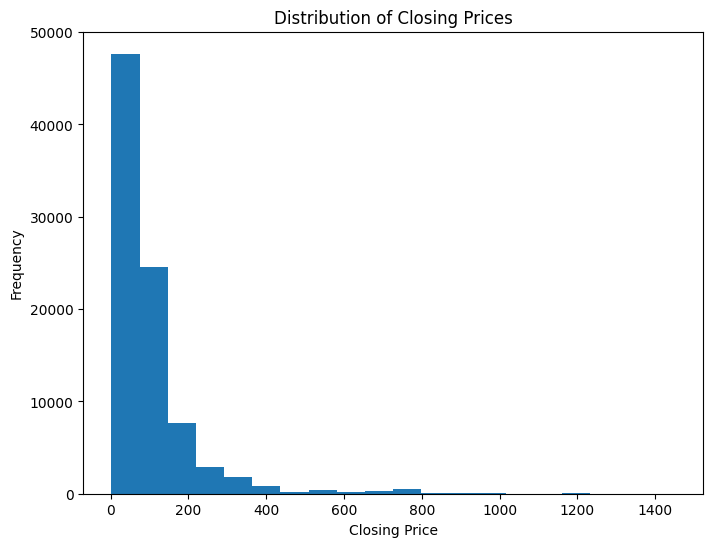

In [9]:
#histogram of closing prices
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for plotting
pandas_df = df.select("Close").toPandas()

# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(pandas_df["Close"], bins=20)
plt.title("Distribution of Closing Prices")
plt.xlabel("Closing Price")
plt.ylabel("Frequency")
plt.show()

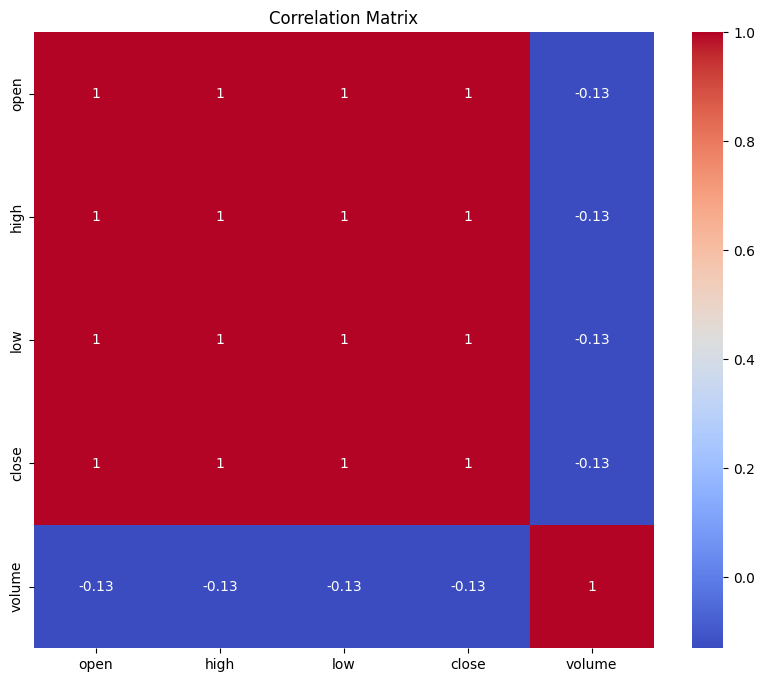

In [10]:
#correlation matrix with heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns
numeric_cols = [c for c, dtype in df.dtypes if dtype in ('double', 'float', 'int', 'bigint')]
numeric_df = df.select(numeric_cols)

# Calculate correlation matrix
corr_matrix = numeric_df.toPandas().corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [13]:
#Daily price changes and volatility
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col, expr

# Create a WindowSpec
window_spec = Window.partitionBy("Date").orderBy("Date")

# Calculate daily price changes using the WindowSpec
df = df.withColumn("PrevClose", lag("Close", 1).over(window_spec))
df = df.withColumn("DailyChange", expr("(Close - PrevClose) / PrevClose"))

# Calculate volatility (standard deviation of daily changes)
volatility = df.agg({"DailyChange": "stddev"})
volatility.show()

+-------------------+
|stddev(DailyChange)|
+-------------------+
| 2.5881346203697104|
+-------------------+



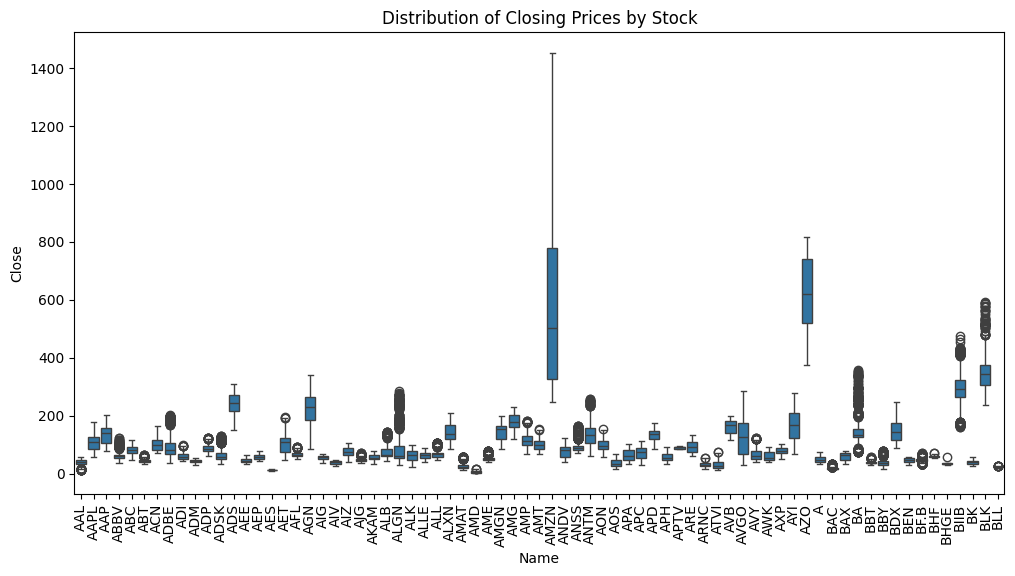

In [12]:
#Boxplot of closing prices for different stocks
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your PySpark DataFrame with 'Name' and 'Close' columns

# Convert to Pandas DataFrame for plotting
pandas_df = df.select("Name", "Close").toPandas()

# Create box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Name", y="Close", data=pandas_df)
plt.title("Distribution of Closing Prices by Stock")
plt.xticks(rotation=90)
plt.show()

## **3: Train a Model**
For stock price prediction, we’ll use a time-series model.

In [14]:
from pyspark.sql.functions import lit

# Create new features
df = df.withColumn("DailyPriceChange", col("High") - col("Low"))
df = df.withColumn("PriceMovement", col("Close") - col("Open"))

# Show the updated DataFrame
df.show(5)

+----------+-------+-------+-------+-------+---------+----+---------+-------------------+------------------+--------------------+
|      Date|   open|   high|    low|  close|   volume|Name|PrevClose|        DailyChange|  DailyPriceChange|       PriceMovement|
+----------+-------+-------+-------+-------+---------+----+---------+-------------------+------------------+--------------------+
|2013-02-11|  14.89|  15.01|  14.26|  14.46|  8882000| AAL|     NULL|               NULL|              0.75| -0.4299999999999997|
|2013-02-11|68.0714|69.2771|67.6071|68.5614|129029425|AAPL|    14.46| 3.7414522821576766|1.6700000000000017|  0.4900000000000091|
|2013-02-11|  78.65|  78.91|  77.23|  78.39|   758016| AAP|  68.5614|0.14335471562716037|1.6799999999999926| -0.2600000000000051|
|2013-02-11|  36.13|  36.18|  35.75|  35.85|  6031957|ABBV|    78.39|-0.5426712590891696|0.4299999999999997|-0.28000000000000114|
|2013-02-11|  46.85|   47.0|   46.5|  46.76|  1115888| ABC|    35.85| 0.3043235704323569| 

## Prepare Data for Training
Split the data into training and testing sets.

In [15]:
# Filter data for a specific stock (e.g., Apple)
stock_df = df.filter(col("Name") == "AAPL")

# Split data into training and testing sets
train_df, test_df = stock_df.randomSplit([0.8, 0.2], seed=42)

In [21]:
from pyspark.sql.functions import col

# Drop the 'features' column if it exists
if 'features' in train_df.columns:
    train_df = train_df.drop('features')
if 'features' in test_df.columns:
    test_df = test_df.drop('features')

# Now apply the VectorAssembler
train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)

In [24]:
# Train a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="close")
lr_model = lr.fit(train_df)

In [26]:
# Make predictions
train_predictions = lr_model.transform(train_df)
test_predictions = lr_model.transform(test_df)

In [28]:
# Evaluate the model
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
train_rmse = evaluator.evaluate(train_predictions)
test_rmse = evaluator.evaluate(test_predictions)

In [29]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 3.966414327675744e-12
Test RMSE: 4.20624359117022e-12


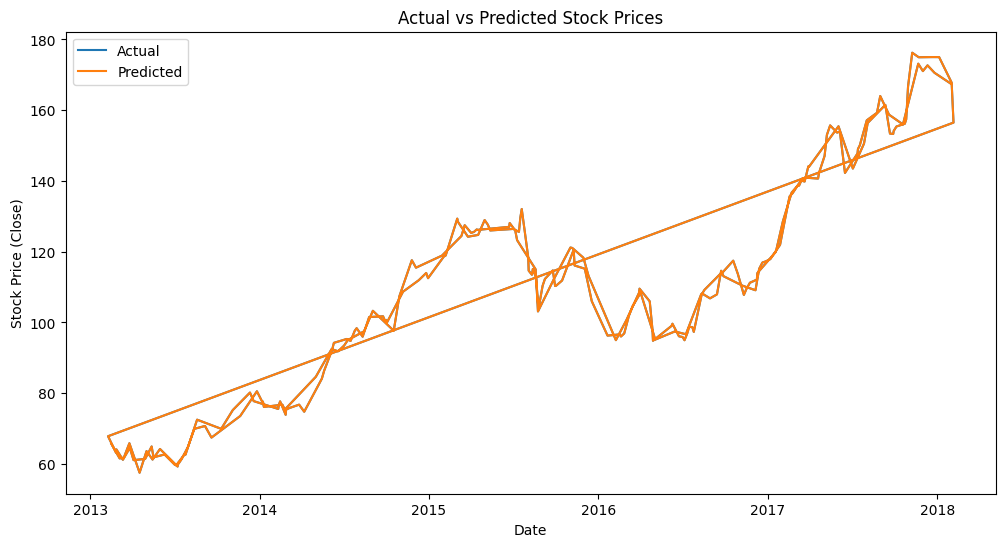

In [30]:
import matplotlib.pyplot as plt

# Convert predictions to Pandas DataFrame for visualization
predictions_pd = test_predictions.select("Date", "close", "prediction").toPandas()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(predictions_pd["Date"], predictions_pd["close"], label="Actual")
plt.plot(predictions_pd["Date"], predictions_pd["prediction"], label="Predicted")
plt.xlabel("Date")
plt.ylabel("Stock Price (Close)")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

In [31]:
# Calculate R-squared
train_r2 = lr_model.summary.r2
test_r2 = evaluator.setMetricName("r2").evaluate(test_predictions)

print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")

Train R²: 1.0
Test R²: 1.0


In [32]:
# Check the feature columns
print(feature_columns)

['open', 'high', 'low', 'volume', 'DailyPriceChange', 'PriceMovement']


In [33]:
# Ensure 'Close' is not in the feature columns
assert 'Close' not in feature_columns, "Target variable 'Close' should not be in feature columns."

In [34]:
# Use only essential features
feature_columns = ["Open", "High", "Low", "Volume"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [36]:
# Re-train the model
lr = LinearRegression(featuresCol="features", labelCol="close")
lr_model = lr.fit(train_df)

# Re-evaluate the model
train_predictions = lr_model.transform(train_df)
test_predictions = lr_model.transform(test_df)

train_rmse = evaluator.evaluate(train_predictions)
test_rmse = evaluator.evaluate(test_predictions)

train_r2 = lr_model.summary.r2
test_r2 = evaluator.setMetricName("r2").evaluate(test_predictions)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R²: {train_r2}")
print(f"Test R²: {test_r2}")

Train RMSE: 1.0
Test RMSE: 1.0
Train R²: 1.0
Test R²: 1.0
